In [ ]:
keras.__version__

In [68]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
base_dir = os.path.dirname(os.getcwd())
print(base_dir)
sys.path.insert(1, base_dir)
from package.api import DB as api
import package.utils as utils
import package.tuning as tuning
utils.check_gpu()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics
#import tensorflow_addons as tfa

import keras_tuner as kt

from keras import backend

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)


%matplotlib inline
%load_ext autoreload
%autoreload 2


log_location = base_dir + '/logs'
model_location = base_dir + '/models'
data_location = base_dir + '/data'

paths_df = pd.read_csv(base_dir + '/paths.csv')
paths_df['path'] = base_dir + '/' + paths_df['path']

W_cols = ['Mach', 'alt', 'TRA', 'T2', 'time']
Xs_cols = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']
aux_cols = ['cycle', 'hs', 'Fc', 'asset_id']

C:\Users\Marcos Quinones\phm2021_data_challenge
2.8.0
[INFO] GPU?: <True> [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
expanding memory growth
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
# Fc = 3
# dataset = 'DS08'

def get_data(Fc=None, dataset=None, downsample=20):

    data_header = f'Fc-{Fc}_dataset-{dataset}'

    params = {'datasource.username': 'macslab', # the username of the logged in user
                'datasource.password': 'Ch0colate!', 
                'datasource.database': 'ncmapss_db', # <- NO CHANGE 
                'datasource.url': '10.2.219.98', # <- or your database installation location
                'datasource.port': '5432'} # <- most likely don't change
    db, cur =  api.connect(params)
    db.set_session(autocommit=True)
    del(params)


    units_df = api._get_units(db=db)
    if Fc is not None and dataset is not None:
        print('here')
        if type(dataset) == type([]):
            dataset = '|'.join(dataset)
        units = units_df[(units_df['Fc'] == Fc) & (units_df['dataset'].str.contains(dataset))]
    elif Fc is not None:
        units = units_df[units_df['Fc'] == Fc]
    elif dataset is not None:
        if type(dataset) == type([]):
            dataset = '|'.join(dataset)
        units = units_df[units_df['dataset'].str.contains(dataset)]


    tables = ['summary_tb', 'telemetry_tb']
    df = api._get_data(db=db,
                       units=pd.unique(units.id),
                       tables=tables,
                       downsample=downsample).astype(np.float32)
    utils.add_time_column(units=pd.unique(units.id), df=df)
    utils.add_rul_column(units=pd.unique(units.id), df=df)
    
    return units_df, units, df, data_header

def preprocess_data(df, scale_output=False):

    scaler = MinMaxScaler()
    model = keras.models.load_model(paths_df[paths_df['name']=='flight_effects_h5'].path.values[0])
    yscaler = joblib.load(paths_df[paths_df['name']=='flight_effects_yscaler'].path.values[0])
    xscaler = joblib.load(paths_df[paths_df['name']=='flight_effects_xscaler'].path.values[0])

    trace = yscaler.transform(df[Xs_cols])
    pred = model.predict(xscaler.transform(df[W_cols]))
    res = trace - pred
    dfx = pd.DataFrame(data=res, columns=Xs_cols)
    df_x = pd.DataFrame(data=xscaler.transform(df[W_cols]), columns=W_cols)
    dfx = pd.concat([dfx, df_x, df[aux_cols]], axis=1)
    if not scale_output:
        dfx['rul'] = df['rul'].values
    else:
        print('scaling output')
        #dfx['rul'] = scaler.fit_transform(df['rul'].values.reshape(-1,1))
        dfx['rul'] = df['rul']/100
    dfx.time = dfx.time + (dfx.cycle -1)
    
    return dfx, scaler

@tf.function
def loss_fcn(y_true, y_pred):
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    diff = y_pred-y_true
        
    pos = []
    neg = []
    
    for d in diff:
        if d < 0:
            neg.append(np.exp(-d/13))
        if d >= 0:
            pos.append(np.exp(d/10))
            
    spos = tf.math.reduce_sum(pos) - 1
    sneg = tf.math.reduce_sum(neg) - 1
    
    s_score = spos + sneg #tf.math.reduce_sum(spos, sneg)
    #print(s_score)
    rmse = tf.math.sqrt(tf.math.reduce_sum(backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)))
 #   print(s_score, rmse)
    score = s_score + rmse
 #   print(score)
    return score / 2.0
    

In [ ]:
lookback = 300
horizon = 1
n_out = 1
n_features = len(x_cols)
input_shape = (lookback, n_features)

monitor = 'val_root_mean_squared_error'
mode = 'min'
min_delta = .1
patience = 10

batch_size =64
epochs = 50

params = []

#params.append(tuning.MyParameters(layers=6, units=16, dropout_rate=.25, learning_rate = .001, recurrent_dropout=0.0, l2=.00001, l1=.00001))
# params.append(tuning.MyParameters(layers=3, units=24, dropout_rate=.2, learning_rate = .00075, recurrent_dropout=0.0, l2=.00001, l1=.00001))
params.append(tuning.MyParameters(layers=3, units=32, dropout_rate=.2, learning_rate = .0005, recurrent_dropout=0.0, l2=.00001, l1=.000001))
# params.append(tuning.MyParameters(layers=3, units=64, dropout_rate=.2, learning_rate = .00075, recurrent_dropout=0.0, l2=.00001, l1=.00001))

horizon = 1
num_outputs = 1
num_layers = 3
num_features = len(x_cols)

input_shape = (None, num_features)


def decay_schedule(epoch, lr):
    if epoch > 1 and epoch < 10:
        lr = lr * .99
    elif epoch >= 10 and epoch < 25:
        lr = lr * .98
    else:
        lr = lr * .97
            
    return lr

lr_scheduler = keras.callbacks.LearningRateScheduler(decay_schedule)

early_stopping = keras.callbacks.EarlyStopping(monitor=monitor,
                                               mode=mode,
                                               min_delta=min_delta,
                                               patience=patience,
                                               verbose=1,
                                               restore_best_weights=True)#True)

In [ ]:
units_df, units, df, data_header = get_data(Fc=3)
dfx, _ = preprocess_data(df)
# dummies = pd.get_dummies(dfx['Fc']).rename(columns=lambda x: f'Fc_{int(x)}')
# dfx = pd.concat([dfx, dummies], axis=1)
# dfx.drop(columns=['Fc'], inplace=True)

In [116]:
x_cols = Xs_cols + W_cols #+ ['Fc_1', 'Fc_2', 'Fc_3']

train_df, train_y, val_df, val_y, test_df, test_y = utils.train_test_split(df=dfx[dfx.hs == 0], 
                                                                           units=list(units.id.values), 
                                                                           y_labels=['rul'], 
                                                                           t_labels=aux_cols + x_cols, 
                                                                           train_pct = .8, val_pct=.1, test_pct=.1, verbose=True)

32
25
3
3
train, val, test set counts: 25, 3, 3
32 31
train units: [2, 10, 44, 77, 23, 81, 27, 82, 64, 79, 83, 31, 5, 16, 78, 18, 35, 61, 84, 54, 57, 51, 67, 85, 21]
val units: [30, 37, 71]
test units: [29, 20, 41, 47]


In [ ]:
min_seq_len = 500
max_seq_len = 2500

traces = []
preds = []
test_units = []

models = []
scores = []


results = {}
results['params'] = params[0].__dict__

lookback = 1200

my_tuning = tuning.Tuning(input_shape, n_out)

model = my_tuning.build_bilstm_model(params[0])

print("temporalizing test and val data")
X_test, y_test = utils.temporalize_data(test_df[x_cols].values, test_y, lookback, horizon, n_features, n_out)
X_val, y_val = utils.temporalize_data(val_df[x_cols].values, val_y, lookback, horizon, n_features, n_out)

X_test = np.array(X_test).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

X_val = np.array(X_val).astype(np.float32)
y_val = np.array(y_val).astype(np.float32)

returning model
temporalizing test and val data


returning model
-----------------  epoch 0  ---------------------------------------------
............  unit 66.0  ...... lookback 754
135/135 [==============================] - 51s 336ms/step - loss: 205.6498 - root_mean_squared_error: 18.2814
............  unit 68.0  ...... lookback 861
153/153 [==============================] - 66s 363ms/step - loss: 169.3031 - root_mean_squared_error: 15.8111
............  unit 69.0  ...... lookback 525
317/317 [==============================] - 91s 275ms/step - loss: 179.6893 - root_mean_squared_error: 16.2378
............  unit 70.0  ...... lookback 798
244/244 [==============================] - 84s 345ms/step - loss: 91.7238 - root_mean_squared_error: 9.2394
............  unit 71.0  ...... lookback 828
464/464 [==============================] - 164s 353ms/step - loss: 98.3668 - root_mean_squared_error: 10.7975
............  unit 72.0  ...... lookback 479
319/319 [==============================] - 83s 260ms/step - loss: 88.4726 - root_mean_square

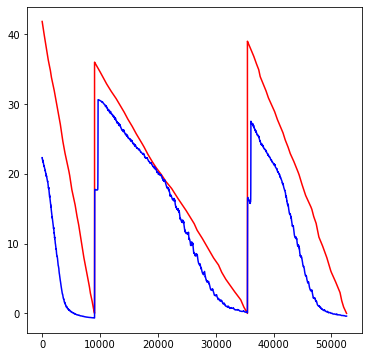

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_0\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_0\assets


-----------------  epoch 1  ---------------------------------------------
............  unit 66.0  ...... lookback 709
136/136 [==============================] - 44s 324ms/step - loss: 55.2997 - root_mean_squared_error: 4.8857
............  unit 68.0  ...... lookback 907
152/152 [==============================] - 58s 379ms/step - loss: 50.8616 - root_mean_squared_error: 3.9939
............  unit 69.0  ...... lookback 951
310/310 [==============================] - 123s 396ms/step - loss: 51.5115 - root_mean_squared_error: 4.1041
............  unit 70.0  ...... lookback 374
251/251 [==============================] - 60s 240ms/step - loss: 41.9718 - root_mean_squared_error: 1.6818
............  unit 71.0  ...... lookback 460
470/470 [==============================] - 121s 258ms/step - loss: 47.2901 - root_mean_squared_error: 3.3676
............  unit 72.0  ...... lookback 772
314/314 [==============================] - 107s 340ms/step - loss: 47.9177 - root_mean_squared_error: 3.3380
.....

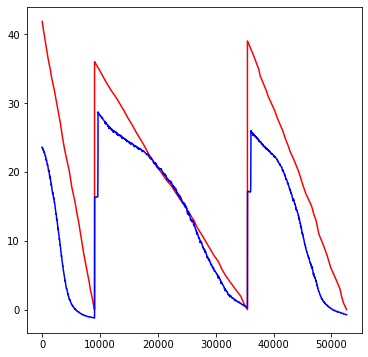

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_1\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_1\assets


-----------------  epoch 2  ---------------------------------------------
............  unit 66.0  ...... lookback 563
138/138 [==============================] - 40s 286ms/step - loss: 54.4138 - root_mean_squared_error: 4.9307
............  unit 68.0  ...... lookback 755
155/155 [==============================] - 53s 340ms/step - loss: 49.2192 - root_mean_squared_error: 3.6351
............  unit 69.0  ...... lookback 913
311/311 [==============================] - 117s 378ms/step - loss: 47.9459 - root_mean_squared_error: 3.4090
............  unit 70.0  ...... lookback 652
246/246 [==============================] - 77s 311ms/step - loss: 42.1340 - root_mean_squared_error: 1.7768
............  unit 71.0  ...... lookback 628
467/467 [==============================] - 141s 301ms/step - loss: 45.3166 - root_mean_squared_error: 2.9593
............  unit 72.0  ...... lookback 866
313/313 [==============================] - 114s 364ms/step - loss: 48.8884 - root_mean_squared_error: 3.6342
.....

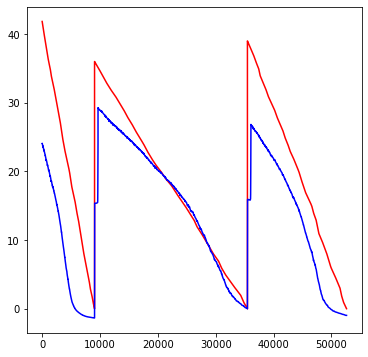

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_2\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_2\assets


-----------------  epoch 3  ---------------------------------------------
............  unit 66.0  ...... lookback 548
138/138 [==============================] - 38s 276ms/step - loss: 56.0545 - root_mean_squared_error: 4.9688
............  unit 68.0  ...... lookback 444
160/160 [==============================] - 40s 247ms/step - loss: 52.7039 - root_mean_squared_error: 4.5613
............  unit 69.0  ...... lookback 694
314/314 [==============================] - 97s 310ms/step - loss: 49.4631 - root_mean_squared_error: 3.8784
............  unit 70.0  ...... lookback 548
248/248 [==============================] - 67s 271ms/step - loss: 41.9226 - root_mean_squared_error: 1.7306
............  unit 71.0  ...... lookback 489
469/469 [==============================] - 120s 256ms/step - loss: 46.0823 - root_mean_squared_error: 3.2294
............  unit 72.0  ...... lookback 971
311/311 [==============================] - 121s 389ms/step - loss: 46.5278 - root_mean_squared_error: 3.1056
......

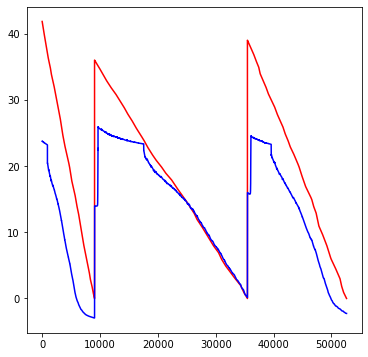

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_3\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_3\assets


-----------------  epoch 4  ---------------------------------------------
............  unit 66.0  ...... lookback 649
137/137 [==============================] - 41s 301ms/step - loss: 56.0373 - root_mean_squared_error: 5.1848
............  unit 68.0  ...... lookback 833
154/154 [==============================] - 53s 344ms/step - loss: 48.9021 - root_mean_squared_error: 3.5192
............  unit 69.0  ...... lookback 810
313/313 [==============================] - 107s 343ms/step - loss: 46.0820 - root_mean_squared_error: 3.0420
............  unit 70.0  ...... lookback 716
245/245 [==============================] - 77s 316ms/step - loss: 44.7214 - root_mean_squared_error: 1.9572
............  unit 71.0  ...... lookback 374
471/471 [==============================] - 109s 231ms/step - loss: 53.6588 - root_mean_squared_error: 4.7884
............  unit 72.0  ...... lookback 519
318/318 [==============================] - 84s 262ms/step - loss: 56.2740 - root_mean_squared_error: 5.0149
......

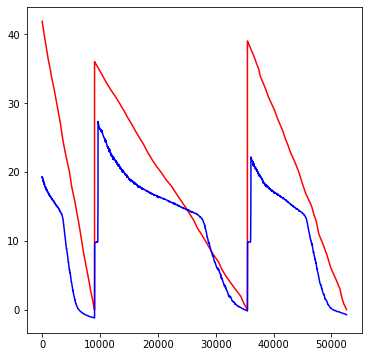

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_4\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_4\assets


-----------------  epoch 5  ---------------------------------------------
............  unit 66.0  ...... lookback 602
138/138 [==============================] - 40s 287ms/step - loss: 63.2064 - root_mean_squared_error: 6.5764
............  unit 68.0  ...... lookback 964
152/152 [==============================] - 59s 386ms/step - loss: 49.8820 - root_mean_squared_error: 3.7333
............  unit 69.0  ...... lookback 936
311/311 [==============================] - 118s 379ms/step - loss: 51.3363 - root_mean_squared_error: 4.2978
............  unit 70.0  ...... lookback 315
252/252 [==============================] - 55s 218ms/step - loss: 43.2852 - root_mean_squared_error: 1.9454
............  unit 71.0  ...... lookback 536
469/469 [==============================] - 127s 270ms/step - loss: 47.3084 - root_mean_squared_error: 3.3086
............  unit 72.0  ...... lookback 847
313/313 [==============================] - 108s 346ms/step - loss: 47.7235 - root_mean_squared_error: 3.3060
.....

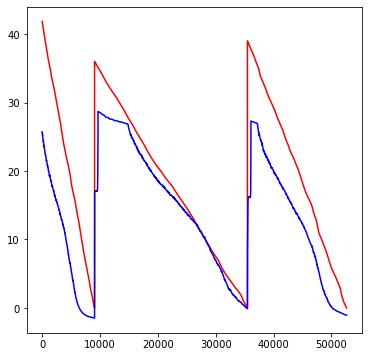

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_5\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_5\assets


-----------------  epoch 6  ---------------------------------------------
............  unit 66.0  ...... lookback 370
141/141 [==============================] - 33s 231ms/step - loss: 56.3218 - root_mean_squared_error: 5.1542
............  unit 68.0  ...... lookback 809
154/154 [==============================] - 53s 345ms/step - loss: 50.2621 - root_mean_squared_error: 4.0151
............  unit 69.0  ...... lookback 670
315/315 [==============================] - 98s 310ms/step - loss: 51.2256 - root_mean_squared_error: 4.3009
............  unit 70.0  ...... lookback 589
247/247 [==============================] - 71s 286ms/step - loss: 44.9882 - root_mean_squared_error: 2.2590
............  unit 71.0  ...... lookback 393
471/471 [==============================] - 113s 240ms/step - loss: 50.6930 - root_mean_squared_error: 4.2941
............  unit 72.0  ...... lookback 838
313/313 [==============================] - 109s 347ms/step - loss: 47.3233 - root_mean_squared_error: 3.3013
......

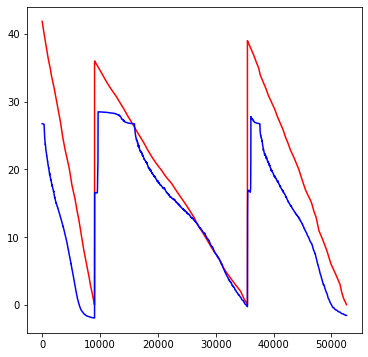

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_6\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_6\assets


-----------------  epoch 7  ---------------------------------------------
............  unit 66.0  ...... lookback 846
134/134 [==============================] - 47s 347ms/step - loss: 50.1077 - root_mean_squared_error: 3.9708
............  unit 68.0  ...... lookback 632
157/157 [==============================] - 47s 296ms/step - loss: 52.0057 - root_mean_squared_error: 4.3470
............  unit 69.0  ...... lookback 449
318/318 [==============================] - 79s 249ms/step - loss: 52.5204 - root_mean_squared_error: 4.4775
............  unit 70.0  ...... lookback 857
243/243 [==============================] - 85s 350ms/step - loss: 47.0770 - root_mean_squared_error: 2.6298
............  unit 71.0  ...... lookback 544
468/468 [==============================] - 127s 271ms/step - loss: 49.1431 - root_mean_squared_error: 4.0388
............  unit 72.0  ...... lookback 313
321/321 [==============================] - 70s 218ms/step - loss: 49.1780 - root_mean_squared_error: 3.7405
.......

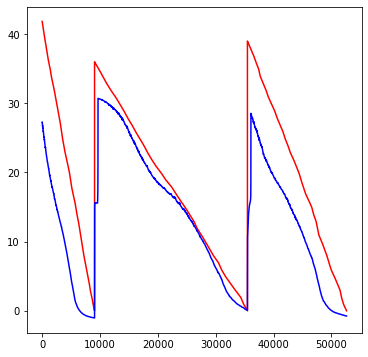

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_7\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_7\assets


-----------------  epoch 8  ---------------------------------------------
............  unit 66.0  ...... lookback 857
134/134 [==============================] - 47s 349ms/step - loss: 49.3676 - root_mean_squared_error: 3.8475
............  unit 68.0  ...... lookback 944
152/152 [==============================] - 57s 375ms/step - loss: 46.7409 - root_mean_squared_error: 3.2506
............  unit 69.0  ...... lookback 693
314/314 [==============================] - 97s 310ms/step - loss: 47.7776 - root_mean_squared_error: 3.4874
............  unit 70.0  ...... lookback 630
247/247 [==============================] - 72s 291ms/step - loss: 47.7228 - root_mean_squared_error: 2.8590
............  unit 71.0  ...... lookback 476
470/470 [==============================] - 120s 256ms/step - loss: 46.8716 - root_mean_squared_error: 3.4153
............  unit 72.0  ...... lookback 682
315/315 [==============================] - 98s 311ms/step - loss: 47.0414 - root_mean_squared_error: 3.2223
.......

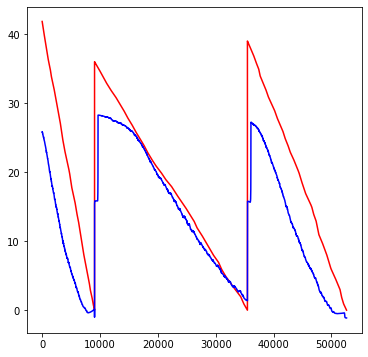

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_8\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_8\assets


-----------------  epoch 9  ---------------------------------------------
............  unit 66.0  ...... lookback 586
138/138 [==============================] - 40s 286ms/step - loss: 53.5104 - root_mean_squared_error: 4.4930
............  unit 68.0  ...... lookback 726
155/155 [==============================] - 50s 321ms/step - loss: 54.0893 - root_mean_squared_error: 4.7199
............  unit 69.0  ...... lookback 892
311/311 [==============================] - 115s 368ms/step - loss: 51.3499 - root_mean_squared_error: 4.2517
............  unit 70.0  ...... lookback 628
247/247 [==============================] - 72s 293ms/step - loss: 43.3554 - root_mean_squared_error: 2.0182
............  unit 71.0  ...... lookback 888
463/463 [==============================] - 168s 364ms/step - loss: 45.5508 - root_mean_squared_error: 2.9897
............  unit 72.0  ...... lookback 332
321/321 [==============================] - 71s 221ms/step - loss: 49.2144 - root_mean_squared_error: 3.6241
......

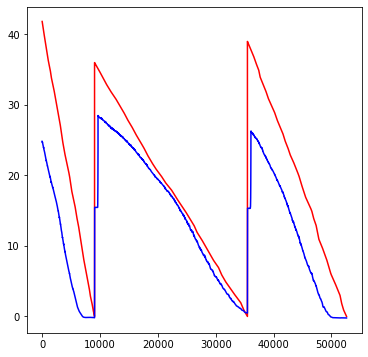

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_9\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_9\assets


-----------------  epoch 10  ---------------------------------------------
............  unit 66.0  ...... lookback 827
134/134 [==============================] - 46s 346ms/step - loss: 53.5254 - root_mean_squared_error: 4.5129
............  unit 68.0  ...... lookback 946
152/152 [==============================] - 57s 377ms/step - loss: 52.4094 - root_mean_squared_error: 4.3313
............  unit 69.0  ...... lookback 300
321/321 [==============================] - 69s 215ms/step - loss: 53.1256 - root_mean_squared_error: 4.6821
............  unit 70.0  ...... lookback 358
251/251 [==============================] - 56s 224ms/step - loss: 41.7822 - root_mean_squared_error: 1.7272
............  unit 71.0  ...... lookback 853
464/464 [==============================] - 160s 345ms/step - loss: 45.0349 - root_mean_squared_error: 2.9435
............  unit 72.0  ...... lookback 610
317/317 [==============================] - 91s 286ms/step - loss: 48.3159 - root_mean_squared_error: 3.5003
......

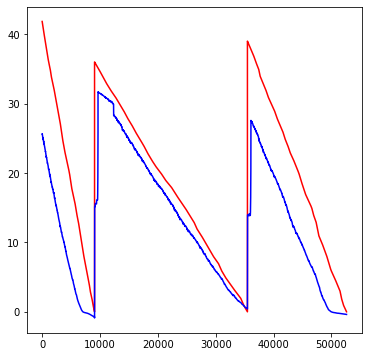

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_10\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_10\assets


-----------------  epoch 11  ---------------------------------------------
............  unit 66.0  ...... lookback 556
138/138 [==============================] - 38s 276ms/step - loss: 51.2575 - root_mean_squared_error: 4.2712
............  unit 68.0  ...... lookback 877
153/153 [==============================] - 55s 361ms/step - loss: 48.3952 - root_mean_squared_error: 3.5168
............  unit 69.0  ...... lookback 963
310/310 [==============================] - 119s 385ms/step - loss: 47.7986 - root_mean_squared_error: 3.5257
............  unit 70.0  ...... lookback 735
245/245 [==============================] - 78s 316ms/step - loss: 42.3938 - root_mean_squared_error: 1.9479
............  unit 71.0  ...... lookback 305
472/472 [==============================] - 101s 214ms/step - loss: 43.4283 - root_mean_squared_error: 2.5278
............  unit 72.0  ...... lookback 911
312/312 [==============================] - 115s 368ms/step - loss: 44.7055 - root_mean_squared_error: 2.5913
....

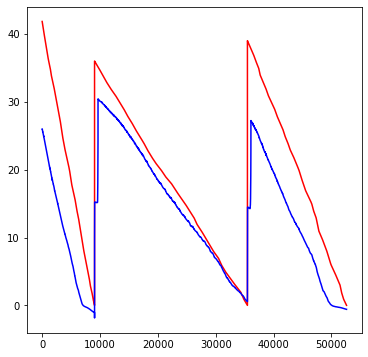

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_11\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_11\assets


-----------------  epoch 12  ---------------------------------------------
............  unit 66.0  ...... lookback 553
138/138 [==============================] - 38s 276ms/step - loss: 51.7981 - root_mean_squared_error: 4.3322
............  unit 68.0  ...... lookback 709
156/156 [==============================] - 49s 313ms/step - loss: 50.0151 - root_mean_squared_error: 3.9311
............  unit 69.0  ...... lookback 936
311/311 [==============================] - 117s 376ms/step - loss: 49.0791 - root_mean_squared_error: 3.8738
............  unit 70.0  ...... lookback 543
248/248 [==============================] - 67s 268ms/step - loss: 44.5569 - root_mean_squared_error: 2.3261
............  unit 71.0  ...... lookback 927
462/462 [==============================] - 170s 368ms/step - loss: 44.8676 - root_mean_squared_error: 2.9627
............  unit 72.0  ...... lookback 841
313/313 [==============================] - 109s 347ms/step - loss: 45.8855 - root_mean_squared_error: 2.9986
....

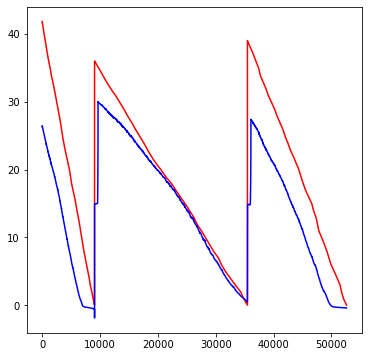

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_12\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_12\assets


-----------------  epoch 13  ---------------------------------------------
............  unit 66.0  ...... lookback 302
142/142 [==============================] - 31s 214ms/step - loss: 52.7590 - root_mean_squared_error: 4.6053
............  unit 68.0  ...... lookback 434
160/160 [==============================] - 39s 245ms/step - loss: 49.7294 - root_mean_squared_error: 3.9318
............  unit 69.0  ...... lookback 348
320/320 [==============================] - 71s 222ms/step - loss: 48.7054 - root_mean_squared_error: 3.7762
............  unit 70.0  ...... lookback 955
242/242 [==============================] - 92s 379ms/step - loss: 48.2788 - root_mean_squared_error: 3.0492
............  unit 71.0  ...... lookback 401
471/471 [==============================] - 111s 236ms/step - loss: 44.3067 - root_mean_squared_error: 2.8190
............  unit 72.0  ...... lookback 759
314/314 [==============================] - 103s 328ms/step - loss: 44.6805 - root_mean_squared_error: 2.6920
.....

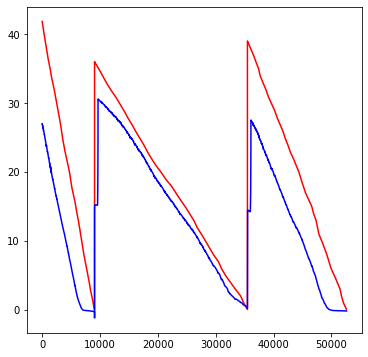

INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_13\assets


INFO:tensorflow:Assets written to: C:\Users\Marcos Quinones\phm2021_data_challenge/models/Fc-None_dataset-DS08/3-layers_32-units_0005_learningRate/model_13\assets


-----------------  epoch 14  ---------------------------------------------
............  unit 66.0  ...... lookback 505
139/139 [==============================] - 37s 264ms/step - loss: 51.2913 - root_mean_squared_error: 4.2357
............  unit 68.0  ...... lookback 829
154/154 [==============================] - 53s 345ms/step - loss: 48.4616 - root_mean_squared_error: 3.5972
............  unit 69.0  ...... lookback 814
312/312 [==============================] - 109s 350ms/step - loss: 48.9247 - root_mean_squared_error: 3.8782
............  unit 70.0  ...... lookback 993


KeyboardInterrupt: 

In [87]:
my_tuning = tuning.Tuning(input_shape, n_out)

model = my_tuning.build_bilstm_model(params[0])

for i in range(0,40):
    y_start = 0
    print(f"-----------------  epoch {i}  ---------------------------------------------")
    for unit in pd.unique(train_df.asset_id):
        
        X_train = train_df[train_df.asset_id == unit]
        X_train.reset_index(inplace=True, drop=True)

        y_end = X_train.shape[0] + y_start
        
        y_train = train_y[y_start:y_end].flatten()

        y_start = y_end
        
        lookback = np.random.randint(min_seq_len, max_seq_len)
        
        print(f"............  unit {unit}  ...... lookback {lookback}")
        
        X_train, y_train = utils.temporalize_data(X_train[x_cols].values, y_train, lookback, horizon, n_features, n_out)

        X_train = np.array(X_train).astype(np.float32)
        y_train = np.array(y_train).astype(np.float32)

        tensorboard = keras.callbacks.TensorBoard(log_dir=f'{log_location}/kmeans/{data_header}/variable/train_unit_{unit}',
                                      histogram_freq=1,
                                      write_images=True,
                                      write_graph=True)

        history = model.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=1,
                            shuffle=False,
                            validation_data=None,#(X_val, y_val),
                            #callbacks=[early_stopping, lr_scheduler, tensorboard],
                            verbose=1)

    test_score = model.evaluate(np.vstack([X_test, X_val]), np.vstack([y_test, y_val]), batch_size=batch_size)
    
    res = model.predict(np.vstack([X_test, X_val]))

    figure = plt.figure(figsize=(6,6))
    plt.plot(np.vstack([y_test, y_val]).flatten(), c='r')
    plt.plot(res.flatten(), c='b')
    plt.show()

    model.save(model_location + '/' + data_header + '/' + str(params[0]) + f'/model_{i}')
    model.save(model_location + '/' + data_header + '/' + str(params[0]) + f'/model_{i}.h5')

    traces.append(y_test.flatten())
    preds.append(res.flatten())
    test_units.append(units.iloc[i].id)

    variables = {"size_kb": os.path.getsize(model_location + '/' + data_header + '/' + str(params[0]) + f'/model_{i}.h5')/1024,
                     "val_rmse": -1,#history.history['val_root_mean_squared_error'][-1], 
                     "test_rmse": test_score[1], 
                     "test_unit": [int(x) for x in pd.unique(test_df.asset_id)], 
                     "val_unit": [int(x) for x in pd.unique(val_df.asset_id)],
                     "trace": [float(x) for x in list(traces[i])],
                     "pred": [float(x) for x in list(preds[i])]
                    }
    results[f'data_{i}'] = variables
    
    models.append(model)
    scores.append([(variables['val_rmse'] + variables['test_rmse']) / 2, variables['val_rmse'], variables['test_rmse']])

    
with open(f'{log_location}/{data_header}_variable.json', 'w') as outfile:
    json.dump(results, outfile)

In [ ]:
for fc in [3, 2, 1]:   
    units_df, units, df, data_header = get_data(fc, dataset)
    print(units.head())
    dfx, _ = preprocess_data(df, scale_output=False)
    #joblib.dump(rul_scaler, model_location + '/' + data_header + 'scaler.pkl')
    dfx0 = dfx[dfx.hs == 0]

    traces = []
    preds = []
    test_units = []
    
    models = []
    scores = []

    K = len(units)
    start = 0
    for j in range(0, len(params)):
        results = {}
        results = {}
        results['params'] = params[j].__dict__

        models.append([])
        scores.append([])

        for i in range(start, K):        
            test_df = dfx0[dfx0.asset_id == units.iloc[i].id]
            test_y = test_df.pop('rul')

            val_unit_id = units[(units.id != units.iloc[i].id) & (units.id != 71) & (units.id != 77) & (units.id != 78) & (units.id != 79)].sample(1).id.values[0]

            val_df = dfx0[dfx0.asset_id == val_unit_id]
            val_y = val_df.pop('rul')

            train_df = dfx0[(dfx0.asset_id != units.iloc[i].id) & (dfx0.asset_id != val_unit_id)]
            train_y = train_df.pop('rul')

            print("temporalizing")
            X_test, y_test = utils.temporalize_data(test_df[W_cols + Xs_cols].values, test_y.values, lookback, horizon, n_features, n_out)
            X_val, y_val = utils.temporalize_data(val_df[W_cols + Xs_cols].values, val_y.values, lookback, horizon, n_features, n_out)

            X_test = np.array(X_test).astype(np.float32)
            y_test = np.array(y_test).astype(np.float32)

            X_val = np.array(X_val).astype(np.float32)
            y_val = np.array(y_val).astype(np.float32)
                
            y_start = 0
            
            for unit in pd.unique(train_df.asset_id):
                y_end = X_train.shape[0] + y_start
                
                X_train = train_df[train_df.asset_id == unit]
                X_train = X_train[x_cols]
                X_train.reset_index(inplace=True, drop=True)

                y_end = X_train.shape[0] + y_start

                y_train = train_y[y_start:y_end].flatten()
                
                y_start = y_end
                
                X_train, y_train = utils.temporalize_data(X_train.values, y_train, lookback, horizon, n_features, n_out)
            
                X_train = np.array(X_train).astype(np.float32)
                y_train = np.array(y_train).astype(np.float32)

                my_tuning = tuning.Tuning(input_shape, n_out)

                model = my_tuning.build_bilstm_model(params[j])

                tensorboard = keras.callbacks.TensorBoard(log_dir=f'{log_location}/kmeans/{data_header}/model_{j}/test_unit_{units.iloc[i].id}/val_unit_{val_unit_id}',
                                              histogram_freq=1,
                                              write_images=True,
                                              write_graph=True)

                history = model.fit(X_train,
                                    y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    shuffle=False,
                                    validation_data=(X_val, y_val),
                                    callbacks=[early_stopping, lr_scheduler, tensorboard],
                                    verbose=1)

                test_score = model.evaluate(X_test, y_test, batch_size=batch_size)

                res = model.predict(X_test)

                traces.append(y_test.flatten())
                preds.append(res.flatten())
                test_units.append(units.iloc[i].id)

                print(f'training on <{[int(x) for x in pd.unique(train_df.asset_id)]}>, validating on <{val_unit_id}>, testing on <{units.iloc[i].id}>')
                figure = plt.figure(figsize=(6,6))
                plt.plot(y_test.flatten(), c='r')
                plt.plot(res.flatten(), c='b')
                plt.show()

                model.save(model_location + '/' + data_header + '/' + str(params[j]) + f'/model_{i}')
                model.save(model_location + '/' + data_header + '/' + str(params[j]) + f'/model_{i}.h5')


                variables = {"size_kb": os.path.getsize(model_location + '/' + data_header + '/' + str(params[j]) + f'/model_{i}.h5')/1024,
                             "val_rmse": history.history['val_root_mean_squared_error'][-1], 
                             "test_rmse": test_score[1], 
                             "test_unit": int(test_units[i]), 
                             "val_unit": int(val_unit_id),
                             "trace": [float(x) for x in list(traces[i])],
                             "pred": [float(x) for x in list(preds[i])]
                            }

                results[f'data_{i}'] = variables

                models[j].append(model)
                scores[j].append([(variables['val_rmse'] + variables['test_rmse']) / 2, variables['val_rmse'], variables['test_rmse']])

        for attribute, value in results.items():
            if 'data' in str(attribute):
                print(results[attribute].keys())
                results[attribute]['pred'] = [float(x) for x in results[attribute]['pred']]
                results[attribute]['trace'] = [float(x) for x in results[attribute]['trace']]
                results[attribute]['test_unit'] = int(results[attribute]['test_unit'])
                results[attribute]['val_unit'] = int(results[attribute]['val_unit'])

        with open(f'{log_location}/{data_header}_{j}.json', 'w') as outfile:
            json.dump(results, outfile)

In [101]:
kfold_data = []
dataset='DS08'
for fc in range(1,4):
    data_header = f"Fc-{fc}_dataset-{dataset}"
    for j in range(3):
        print(f'{log_location}/{data_header}_{j}.json')
        with open(f'{log_location}/{data_header}_{j}.json', 'r') as f:
            kfold_data.append(json.loads(f.read()))

C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-1_dataset-DS08_0.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-1_dataset-DS08_1.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-1_dataset-DS08_2.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-2_dataset-DS08_0.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-2_dataset-DS08_1.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-2_dataset-DS08_2.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-3_dataset-DS08_0.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-3_dataset-DS08_1.json
C:\Users\Marcos Quinones\phm2021_data_challenge/logs/Fc-3_dataset-DS08_2.json


In [100]:
#model_location + '/' + data_header + '/' + str(params[j])

In [ ]:
kfold_data = []
for i in range(3):
    with open(f'kfold_data_{i}.json', 'r') as f:
        kfold_data.append(json.loads(f.read()))

In [105]:
for i in range(len(kfold_data)):
    print(kfold_data[i].keys())

dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])
dict_keys(['params', 'data_0', 'data_1', 'data_2', 'data_3', 'data_4', 'data_5', 'data_6', 'data_7', 'data_8', 'data_9'])


In [ ]:
test_rmse_vals = np.zeros((10,3))
val_rmse_vals = np.zeros((10,3))
for i in range(3):
    print(f"model_{i}")
    for j in range(10):
        print(kfold_data[i][f'model_{i}'][f'data_{j}']['val_rmse'])
        val_rmse_vals[j,i] = kfold_data[i][f'model_{i}'][f'data_{j}']['val_rmse']
        test_rmse_vals[j,i] = kfold_data[i][f'model_{i}'][f'data_{j}']['test_rmse']

In [ ]:
test_rmse_df = pd.DataFrame(test_rmse_vals, columns=['m1', 'm2', 'm3'])

In [ ]:
test_rmse_df = test_rmse_df.drop([1,2,3,4])
test_rmse_df

In [ ]:
val_rmse_df = pd.DataFrame(val_rmse_vals, columns=['m1', 'm2', 'm3'])

In [ ]:
test_rmse_df

In [ ]:
sizes = np.array([24, 32, 64])
scores = np.array([np.mean(test_rmse_df['m1'].values), np.mean(test_rmse_df['m1'].values), np.mean(test_rmse_df['m3'].values)])
stds = np.array([np.std(test_rmse_df['m1'].values), np.std(test_rmse_df['m1'].values), np.std(test_rmse_df['m1'].values)])

results_df = pd.DataFrame(np.stack([sizes, scores, stds], axis=1), columns = ['size', 'mean', 'std'])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=results_df, s=250, x='size', y='mean', hue='size', palette='Dark2', legend=False)
sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] + results_df['std'], marker='^', hue=results_df['size'],
                palette='Dark2', legend=False)
sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] - results_df['std'], marker='v', hue=results_df['size'],
                palette='Dark2', legend=False)

for i in range(len(results_df)):
        plt.plot([results_df['size'][i], results_df['size'][i]],
                 [results_df['mean'][i] - results_df['std'][i], results_df['mean'][i] + results_df['std'][i]], color='gray')
        
        
# sizes = np.array([24, 32, 64])
# scores = np.array([np.mean(val_rmse_df['m1'].values), np.mean(val_rmse_df['m1'].values), np.mean(val_rmse_df['m3'].values)])
# stds = np.array([np.std(val_rmse_df['m1'].values), np.std(val_rmse_df['m1'].values), np.std(val_rmse_df['m1'].values)])

# results_df = pd.DataFrame(np.stack([sizes, scores, stds], axis=1), columns = ['size', 'mean', 'std'])

# sns.scatterplot(data=results_df, s=250, x='size', y='mean', hue='size', palette='Dark2', legend=False)
# sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] + results_df['std'], marker='^', hue=results_df['size'],
#                 palette='Dark2', legend=False)
# sns.scatterplot(x=results_df['size'], s=150, y=results_df['mean'] - results_df['std'], marker='v', hue=results_df['size'],
#                 palette='Dark2', legend=False)

# for i in range(len(results_df)):
#         plt.plot([results_df['size'][i], results_df['size'][i]],
#                  [results_df['mean'][i] - results_df['std'][i], results_df['mean'][i] + results_df['std'][i]], color='gray')
        
        
        
plt.title('kfold test scores for 3 models')
plt.show()

In [ ]:
units.id.values

In [ ]:
x = np.arange(0,10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.text(i-.5, .5, f'unit {units.id.values[i]}')
    for j in range(3):
        plt.scatter(x[i], test_rmse_vals[i,j], c='r')
        
    for j in range(3):
        plt.scatter(x[i], val_rmse_vals[i,j], c='g')
        
plt.title('test unit scores for 3 models')
plt.show()

In [ ]:
for i in range(3):
    print(f"model_{i}")
    for j in range(10):
        plt.figure(figsize=(6,6))
        plt.plot(kfold_data[i][f'model_{i}'][f'data_{j}']['pred'], c='r', label='pred')
        plt.plot(kfold_data[i][f'model_{i}'][f'data_{j}']['trace'], c='b', label='trace')
        plt.legend()
        plt.show()